In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import logging
logging.basicConfig(filename='error.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
import pickle
from gensim import corpora
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm, tqdm_notebook, tnrange
from sklearn.externals import joblib
import numpy as np
from math import sqrt

In [38]:
train = pd.read_csv("../data/processed/comedy_comparisons.train")
test = pd.read_csv("../data/processed/comedy_comparisons.test")

In [35]:
def feature_sum_score(dataset_df):
    """
    This functions creates a score for each video which is the sum(better)-sum(worse)
    :param dataset_df: The dataset panda dataframe
    :return: Normalized series with the final score [-1..1] and the video_id's as index
    """
    better1 = dataset_df[dataset_df.funnier == 'left'].video_id1.sort_index().value_counts()
    better2 = dataset_df[dataset_df.funnier == 'right'].video_id2.sort_index().value_counts()
    better = better1.add(better2, fill_value=0).sort_index()
    worse1 = dataset_df[dataset_df.funnier == 'right'].video_id1.sort_index().value_counts()
    worse2 = dataset_df[dataset_df.funnier == 'left'].video_id2.sort_index().value_counts()
    worse = worse1.add(worse2, fill_value=0).sort_index()
    score = better.subtract(worse, fill_value=0).sort_index()
    max_score = score.abs().max()
    assert max_score != 0
    norm_score = score / max_score

    return norm_score

In [36]:
score_train = feature_sum_score(train)
score_test = feature_sum_score(test)

In [5]:
def get_corpus(df, dictionary, pbar=None):
    corpus = []
    df1 = {}
    for i, row in enumerate(df.itertuples()):
        curbow = dictionary.doc2bow(tokenize(row.textDisplay))
        corpus.append(curbow)
        if not pbar is None:
            pbar.update(1)
    #corpus['score'] = get_label(df, score, dictionary)
    return corpus

In [6]:
def get_label(df, score, dictionary):
    label = []
    for i, row in enumerate(df.itertuples()):
        if row.videoId in score:
            label.append(score[row.videoId])
        else:
            label.append(0)
    return label

In [7]:
data = pd.read_csv("../data/processed/train_dataset_with_lang_feature.csv")
data_en = data[data.language == 'en']
len(data_en)
data_en.head(10)

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,videoId,textDisplay,isReplyTo,canReply,totalReplyCount,kind,etag,id,authorChannelId,authorDisplayName,likeCount,publishedAt,updatedAt,viewerRating,language
0,0,sNabaB-eb3Y,They should made this as a double prank.. when...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/_aVRgxW14TFYS3sZy...",z23vvfnwmozww3ukvacdp433u2l5tjjzue32obodyxlw03...,{'value': 'UCDjudKsbl2T2KeanD-nrKXw'},Grise Blacolar,0,2013-05-15T16:41:33.000Z,2013-05-15T16:41:33.000Z,none,en
1,1,sNabaB-eb3Y,People are friendlier here than in other state...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/AOKhrA3U9J8iGUkun...",z22uxrrpaxiuyj5ri04t1aokg2ftoiu5vmacden0g5hzbk...,{'value': 'UCLBkXylBjiV0mN1dNhjIRbg'},alphacino,0,2012-11-04T16:32:45.000Z,2012-11-04T16:32:45.000Z,none,en
2,2,sNabaB-eb3Y,"I do live in Texas, how did you guess?!?!?!?!﻿",NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/gxMEOZY-YvfKneJSI...",z222innj3rmgxhlzp04t1aokg5c1sf24ibuxgughzte0rk...,{'value': 'UCXc-CFxsN7iXSL6X4-dDfYQ'},Lumilan,0,2012-11-04T16:21:29.000Z,2012-11-04T16:21:29.000Z,none,en
3,3,sNabaB-eb3Y,you mist live in texas. or maybe new york. you...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/K88xlkocl8TtWTMMt...",z22uxrrpaxiuyj5ri04t1aokgvgnbgrn4ewpkvjulgacrk...,{'value': 'UCLBkXylBjiV0mN1dNhjIRbg'},alphacino,0,2012-11-04T13:43:51.000Z,2012-11-04T13:43:51.000Z,none,en
4,4,sNabaB-eb3Y,They should have just opened the door with the...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/3NozddevGyZcalCaO...",z23tdtdihp3sz3emtacdp43afln2va1zwj4c2wnmljxw03...,{'value': 'UCY8-Q3GTP-a4yZ99GpG4Qww'},PandaMagicFTW,0,2012-10-02T21:35:52.000Z,2012-10-02T21:35:52.000Z,none,en
5,5,sNabaB-eb3Y,i love the music on JFL﻿,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/IRtPfKJcI4PawitZJ...",z23nebibyze2cb3pn04t1aokgkzznfqtt5wqaf5ebm3nbk...,{'value': 'UCXX6ufMotDsRRMj_1BiBk_w'},kimmyw010,0,2012-08-25T04:50:19.000Z,2012-08-25T04:50:19.000Z,none,en
6,6,sNabaB-eb3Y,It has 6 human power﻿,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/mi6gcIdUHEWkn0TKZ...",z23pzpz5vvmrjji0facdp4350cxxomrhh0vdeykuf4tw03...,{'value': 'UCbigvKFMTwsUX1FBhvYY6Tg'},SlickR12345,0,2012-06-26T12:59:15.000Z,2012-06-26T12:59:15.000Z,none,en
7,7,sNabaB-eb3Y,JustForLaughs is like an institution. Loads of...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/d1OXVB16zaiNit0kA...",z22yjr1grzrdeviap04t1aokgb1oyubgsfvzaxkrilrgbk...,{'value': 'UCS3Ri5tvGweVXwzUDGd-8RQ'},TheCulturalBomb,0,2012-06-20T02:17:52.000Z,2012-06-20T02:17:52.000Z,none,en
8,8,sNabaB-eb3Y,thumbs up if you saw the lauriel and hardy pos...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/vqHiKYG7jh576wOsi...",z224tfyjmkrjhffqm04t1aokgr10lkpvdkr5hv23chkebk...,{'value': 'UCih6jccG8q_rVCkqRcm3avQ'},MiguelBug,0,2012-05-16T13:22:37.000Z,2012-05-16T13:22:37.000Z,none,en
9,9,sNabaB-eb3Y,look at the shape of the key @1:11....lol lol ...,NaN,NaN,0,youtube#commentThread,"""I_8xdZu766_FSaexEaDXTIfEWc0/xzPbrBd0AJEttdE_c...",z23qjnzo2xz0ujr4a04t1aokggyigqzp4h4hecowxdz2rk...,{'value': 'UCCWyqVEPJS3v53ggTYfRGNA'},varkyjas10,0,2012-03-27T10:05:55.000Z,2012-03-27T10:05:55.000Z,none,en


In [8]:
data_test = pd.read_csv("../data/processed/test_dataset_with_lang_feature.csv")
data_test_en = data_test[data_test.language == 'en']
len(data_test_en)

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2312215

In [9]:
seed = 85
dat = data.sample(10000, random_state=seed)
dat_test = data_test.sample(1000, random_state=seed)
all_data = pd.concat([dat, dat_test])
len(all_data)

11000

In [11]:
def tokenize(text):
    ret = []
    i = 0
    token = ""
    try:
        for token in simple_preprocess(text):
            if token not in STOPWORDS:
                ret.append(token)
            i = i + 1
        #ret = [token for token in simple_preprocess(text) if token not in STOPWORDS]
    except Exception as e:
        logging.error("Error in line: ", i, " cur token:", token, " error", e)
        pass
        # print("ERROR in line: ", i)
        # print("Cur token", token)
        # print("ERROR: ", e)
    return ret
        
        

def iter_comments(commentsIterable):
    for entry in commentsIterable:
        comment = tokenize(entry[2])
        yield entry[1], comment

In [15]:
# Create a corpus out of the comments and save it
commentsList = data_en[['videoId', 'textDisplay']].dropna().itertuples()
stream = iter_comments(commentsList)
doc_stream = (tokens for _, tokens in stream)
id2word = gensim.corpora.Dictionary(doc_stream)
id2word.save('../data/processed/youtube_comments_en.dict')

In [16]:
len(id2word)

685091

In [7]:
id2word = gensim.corpora.Dictionary.load('../data/processed/youtube_comments.dict')

In [10]:
def tokenize(text):
    ret = []
    i = 0
    token = ""
    try:
        for token in simple_preprocess(text):
            if token not in STOPWORDS:
                ret.append(token)
            i = i + 1
        #ret = [token for token in simple_preprocess(text) if token not in STOPWORDS]
    except Exception as e:
        pass
        # print("ERROR in line: ", i)
        # print("Cur token", token)
        # print("ERROR: ", e)
    return ret
        

In [17]:
dat = data
dat_test = data_test
all_data = pd.concat([data_en, data_test_en])

In [18]:
pbar = tqdm_notebook(range(len(all_data)), desc="Creating corpus")
corpus = get_corpus(all_data, id2word, pbar)
scipy_corpus = gensim.matutils.corpus2csc(corpus)
label = get_label(dat, score_train, id2word)

In [19]:
corpora.MmCorpus.serialize('../data/processed/fullcorpus_en.mm', corpus)

In [8]:
corpus = corpora.MmCorpus('../data/processed/fullcorpus.mm')


In [9]:
scipy_corpus = gensim.matutils.corpus2csc(corpus)


In [20]:
label = get_label(data_en, score_train, id2word)

In [23]:
training_size = len(data_en)
scipy_train = scipy_corpus[:, 0:training_size]

In [24]:
# Create linear regression object
regr = linear_model.LinearRegression(n_jobs=-1)

# Train the model using the training sets
regr.fit(scipy_train.transpose(), label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [25]:
joblib.dump(regr, '../models/linear_regression_en.pkl')

['../models/linear_regression_en.pkl',
 '../models/linear_regression_en.pkl_01.npy']

In [10]:
regr = joblib.load('../models/linear_regression.pkl')

In [29]:
scipy_test = scipy_corpus[:, training_size:]
label_test = get_label(data_test_en, score_test, id2word)

In [30]:
print('Variance score: %.2f' % regr.score(scipy_train.transpose(), label))

Variance score: 0.23


In [31]:
y_true = label_test
y_pred = regr.predict(scipy_test.transpose())
r2 = r2_score(y_true, y_pred)
mean_sq_error = sqrt(mean_squared_error(y_true, y_pred))
r2, mean_sq_error

(-0.25733455463743304, 0.017265985808022313)

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


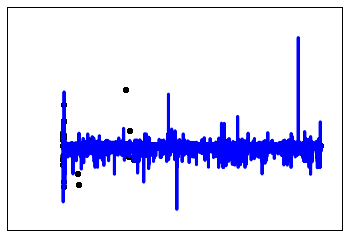

In [32]:
plt.scatter(range(len(label_test)), label_test,  color='black')
plt.plot(range(len(label_test)), regr.predict(scipy_test.transpose()), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [30]:
len(label_test)

3302579

In [31]:
len(data_test_en)

2312215

In [27]:
scipy_test.transpose()

<3302579x1109099 sparse matrix of type '<class 'numpy.float64'>'
	with 15858654 stored elements in Compressed Sparse Row format>

In [47]:
scipy_test=scipy_test.transpose()

In [41]:
video_id = np.array(data_test_en['videoId'])

In [42]:
video_id == '7VvBnz1Ngi4'

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [43]:
len(y_pred)

2312215

In [48]:
scipy_test.shape

(2312215, 685091)

In [49]:
comm_pred = regr.predict(scipy_test[video_id == '7VvBnz1Ngi4'])
sum(comm_pred)/len(comm_pred)

0.0055385235013960471

In [50]:
def video_score(df, video_id1):
    to_pred = df[video_id == video_id1]
    if to_pred.shape[0] == 0:
        return 0.0
    comm_pred1 = regr.predict(to_pred)
    pred1 = 0
    if len(comm_pred1) != 0:
        pred1 = sum(comm_pred1)/len(comm_pred1)
    return pred1

pbar = tqdm_notebook(range(len(test)), desc="Predicting which video is funnier")
ret = []
for row in test.itertuples():
    #print(row.video_id1)
    pred1 = video_score(scipy_test, row.video_id1)
    pred2 = video_score(scipy_test, row.video_id2)
    ret += ['left'] if pred1 >= pred2 else ['right']
    pbar.update(1)
pickle.dump(ret, open('funnier_predictions', 'wb'))
ret

['left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 

In [65]:
len('left')

4

In [67]:
pickle.dump(ret, open('funnier_predictions', 'wb'))
funnier_test = []
i = 0
while i < len(ret):
    if ret[i] == 'l':
        funnier_test += ['left']
        i += len('left')
    elif ret[i] == 'r':
        funnier_test += ['right']
        i += len('right')
    else:
        raise Exception('Wrong!')
funnier_test


['left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'rig

In [70]:
pickle.dump(funnier_test, open('funnier_predictions', 'wb'))


In [52]:
from sklearn.metrics import confusion_matrix
funnier_test = ret
y_true = test.funnier
y_pred = funnier_test
confusion_matrix(y_true, y_pred)

array([[10089,  8795],
       [ 9383, 10330]])

Confusion matrix, without normalization
[[10089  8795]
 [ 9383 10330]]
Normalized confusion matrix
[[ 0.53  0.47]
 [ 0.48  0.52]]


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


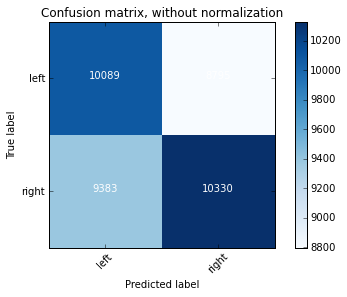

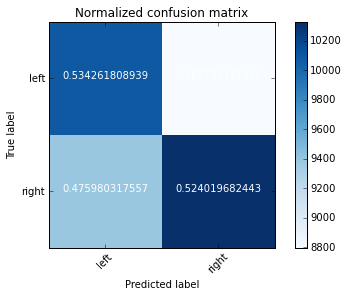

In [53]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_test = test.funnier
y_pred = funnier_test
class_names = ['left', 'right']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [89]:
from sklearn.metrics import roc_auc_score
bin_ytest = [0 if x == 'left' else 1 for x in y_test]
bin_ypred = [0 if x == 'left' else 1 for x in y_pred]
roc_auc_score(bin_ytest, bin_ypred)

0.53164113592862061

In [90]:
from sklearn.metrics import f1_score
f1_score(bin_ytest, bin_ypred)


0.53475027661271646

In [22]:
regr.residues_

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


55.35168563838448

In [ ]:
# cross validation in the training set
#array_train = scipy_train.toarray()
#X = array_train.transpose()
X = scipy_train.transpose()
Y = label
num_folds = 100
num_instances = len(array_train)

In [ ]:
seed = 85
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = linear_model.LinearRegression()
scoring = 'mean_squared_error'

In [ ]:
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)

In [23]:
y_pred

array([  4.69489476e-04,   2.01457183e-04,   1.58268063e-02, ...,
        -1.71507470e-05,   1.37444097e-04,   5.45909678e-04])

In [30]:
len(y_pred)

3302579

In [37]:
scipy_test.shape[1]

3302579

In [38]:
data_test = pd.read_csv("../data/processed/test_dataset_with_lang_feature.csv", usecols=["videoId", "language"])
data_test_en = data_test[data_test.language == 'en']

In [49]:
abs(y_true[0:100] - y_pred[0:100])

array([  7.35829917e-03,   7.62633147e-03,   7.99901764e-03,
         7.71453452e-03,   7.67153479e-03,   7.27581953e-03,
         7.69271854e-03,   1.69077527e-02,   7.88125476e-03,
         7.71390734e-03,   5.62336135e-03,   6.88765657e-03,
         7.35528951e-03,   2.98176065e-03,   6.52931431e-03,
         8.08132795e-03,   3.18392141e-03,   8.25838991e-03,
         6.32018542e-03,   6.92705605e-03,   5.52418351e-03,
         9.87661070e-03,   8.77946834e-03,   7.25144446e-03,
         8.16230046e-03,   6.76981478e-03,   5.54015845e-03,
         7.74499825e-03,   9.76538354e-03,   7.88825711e-03,
         7.69524550e-03,   4.60531413e-02,   1.40600123e-02,
         6.47121088e-03,   7.48186833e-03,   1.31041487e-08,
         2.12433567e-01,   2.36854121e-01,   2.12393277e-01,
         2.40847834e-01,   2.25669176e-01,   2.12392864e-01,
         2.37185825e-01,   2.36029740e-01,   2.36562467e-01,
         2.38264018e-01,   2.37204077e-01,   2.31999283e-01,
         1.31041487e-08,

In [43]:
np.set_printoptions(threshold=np.nan)

In [52]:
y_true[0:100]

[0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0.0078277886497064575,
 0,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362034,
 -0.23679060665362

In [53]:
y_pred[0:100]

array([  4.69489476e-04,   2.01457183e-04,   1.58268063e-02,
         1.13254130e-04,   1.56253863e-04,   5.51969124e-04,
         1.35070114e-04,  -9.07996402e-03,  -5.34661094e-05,
         1.13881314e-04,   2.20442730e-03,   9.40132075e-04,
         4.72499141e-04,   1.08095493e-02,   1.29847434e-03,
        -2.53539300e-04,   4.64386724e-03,  -4.30601259e-04,
         1.50760323e-03,   9.00732597e-04,   2.30360514e-03,
        -2.04882205e-03,  -9.51679690e-04,   5.76344191e-04,
        -3.34511806e-04,   1.05797387e-03,   2.28763020e-03,
         8.27904018e-05,  -1.93759489e-03,  -6.04684590e-05,
         1.32543152e-04,   5.38809299e-02,  -6.23222366e-03,
         1.35657777e-03,   3.45920315e-04,   1.31041487e-08,
        -2.43570396e-02,   6.35144007e-05,  -2.43973298e-02,
         4.05722691e-03,  -1.11214311e-02,  -2.43977429e-02,
         3.95218181e-04,  -7.60866755e-04,  -2.28139684e-04,
         1.47341164e-03,   4.13470532e-04,  -4.79132327e-03,
         1.31041487e-08,

In [ ]:
def get_corpus_by_video_id(df, video_id, dictionary, pbar=None):
    corpus = []
    df1 = {}
    for i, row in enumerate(df.itertuples()):
        curbow = dictionary.doc2bow(tokenize(row.textDisplay))
        corpus.append(curbow)
        if not pbar is None:
            pbar.update(1)
    #corpus['score'] = get_label(df, score, dictionary)
    return corpus